In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc

# setting the info i get from scanpy package
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

ModuleNotFoundError: No module named 'scanpy'

In [2]:
sc.logging.print_versions()

scanpy==1.3.6 anndata==0.6.15 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
#Making a output file location
import os
os.getcwd()

'/home/gunnar/Desktop/JuPyteR'

In [4]:
# results_file = '/home/gunnar/Desktop/pbmc3k.h5ad'
results_file = '/home/gunnar/Desktop/68k_pbmcs_test_data_set/test2.h5ad'

In [5]:
sc.settings.set_figure_params(dpi=80)

In [6]:
# reading in data
# jupyter will create a cache file
adata = sc.read_10x_mtx("/home/gunnar/Desktop/68k_pbmcs_test_data_set/filtered_matrices_mex/hg19/",var_names='gene_symbols', cache=True)

... reading from cache file ./cache/home-gunnar-Desktop-68k_pbmcs_test_data_set-filtered_matrices_mex-hg19-matrix.h5ad


In [7]:
#Note: In notebooks and jupyter lab, you can see the documentation for a python function 
# by hitting SHIFT + TAB. Hit it twice to expand the view.
adata.var_names_make_unique()

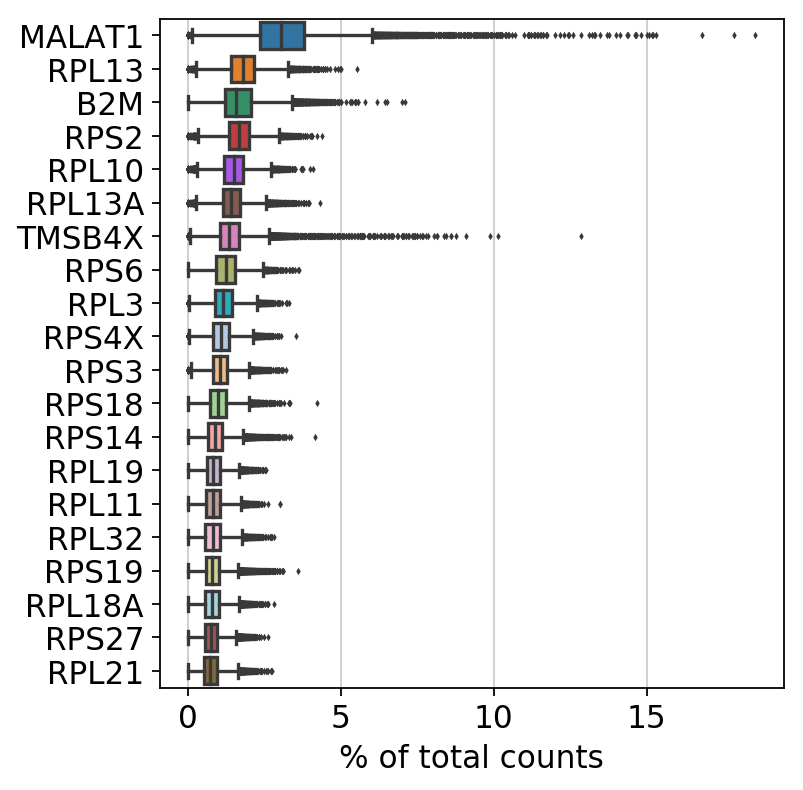

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
# basic filtering 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 28 cells that have less than 200 genes expressed
filtered out 14950 genes that are detected in less than 3 cells


In [10]:
# if you ever have high mito-gene concentration then it possibly is indicative of 
# poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of 
# loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria 
# are larger than individual transcript molecules and less likely to escape through 
# tears in the cell membrane.
# Plot some information about mitochondrial genes, important for quality control. 
# Note that you can also retrieve mitochondrial genes using 
# sc.queries.mitochondrial_genes('www.ensembl.org', 'hsapiens')

In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

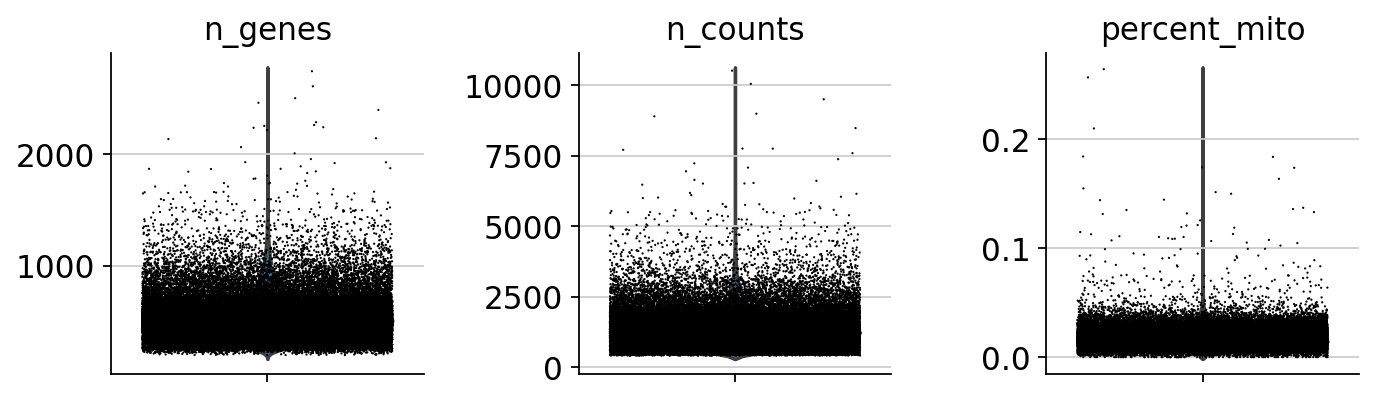

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

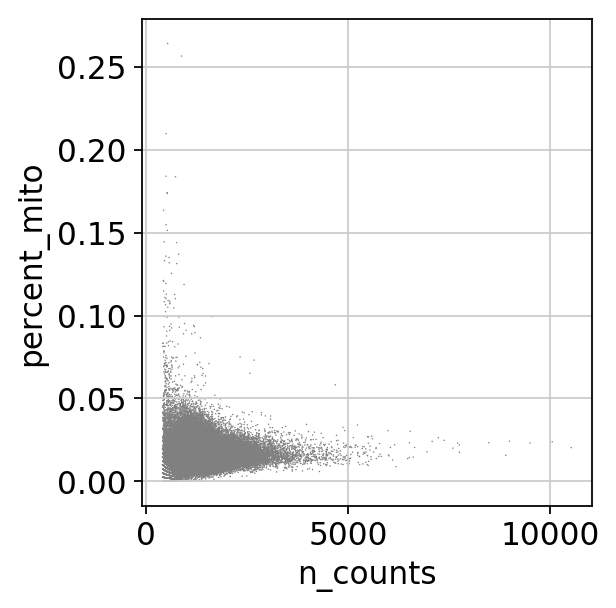

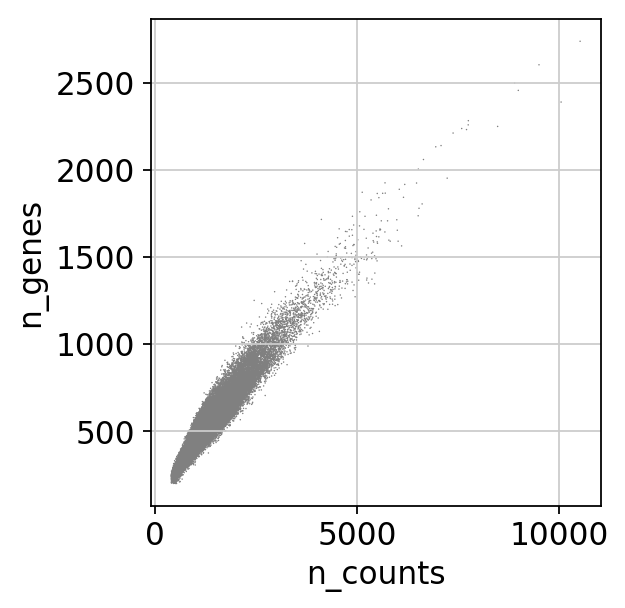

In [17]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts.
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [18]:
adata

AnnData object with n_obs × n_vars = 68551 × 17788 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [19]:
# Actually do the filtering.
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [20]:
# Per-cell normalize (library-size correct) the data matrix X, so that counts become comparable among cells.
# Logarithmize the data.
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

In [21]:
# Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use 
# in differential testing and visualizations of gene expression. This simply freezes the state of 
# the AnnData object. While many people consider the normalized data matrix as the "relevant data" 
# for visualization and differential testing, some would prefer to store the unnormalized data.
adata.raw = adata

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', boolean vector (adata.var)
    'dispersions', boolean vector (adata.var)
    'dispersions_norm', boolean vector (adata.var)


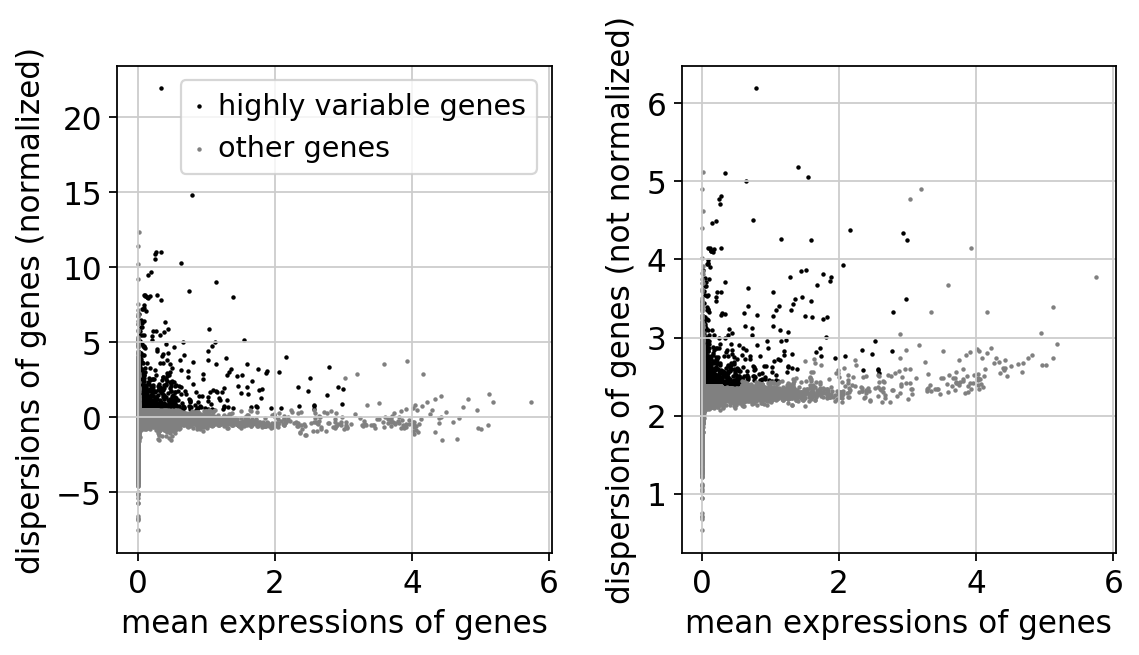

In [23]:
sc.pl.highly_variable_genes(adata,log=False)

In [22]:
# Actually do the filtering.
adata = adata[:, adata.var['highly_variable']]
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:01:30.09)


In [23]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)
#Save the result.
adata.write(results_file)

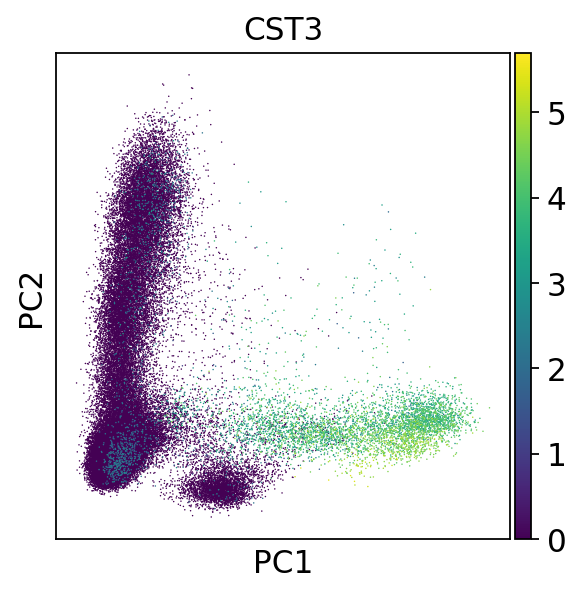

In [26]:
# Compute PCA and make a scatter plot.
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often, a rough estimate of the number of PCs 
# does fine. Seurat provides many more functions, here.

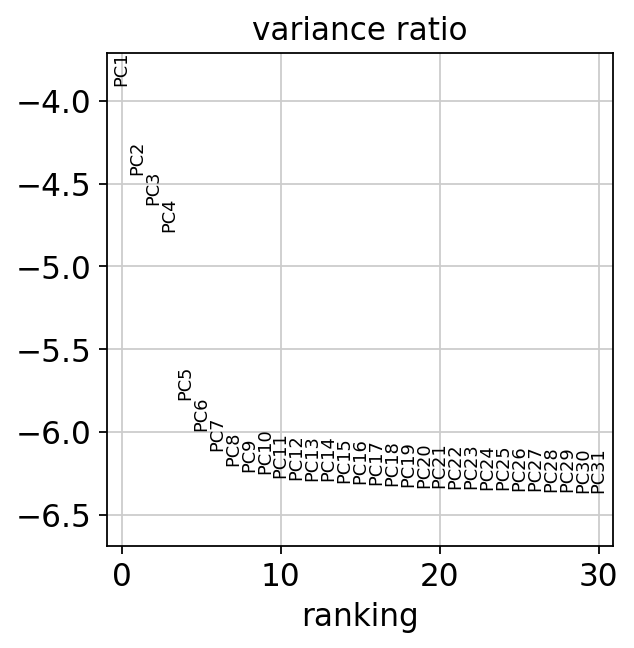

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
# Computing the neighborhood graph
adata = sc.read(results_file)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# We now advertise visualizing the data using UMAP, see below. In particular, 
# if you have large data, this will give you a notable speedup. Also, it is 
# potentially more faithful to global topology: trajectories are better preserved.

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:03.82) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [26]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:06.39) --> added
    'X_umap', UMAP coordinates (adata.obsm)


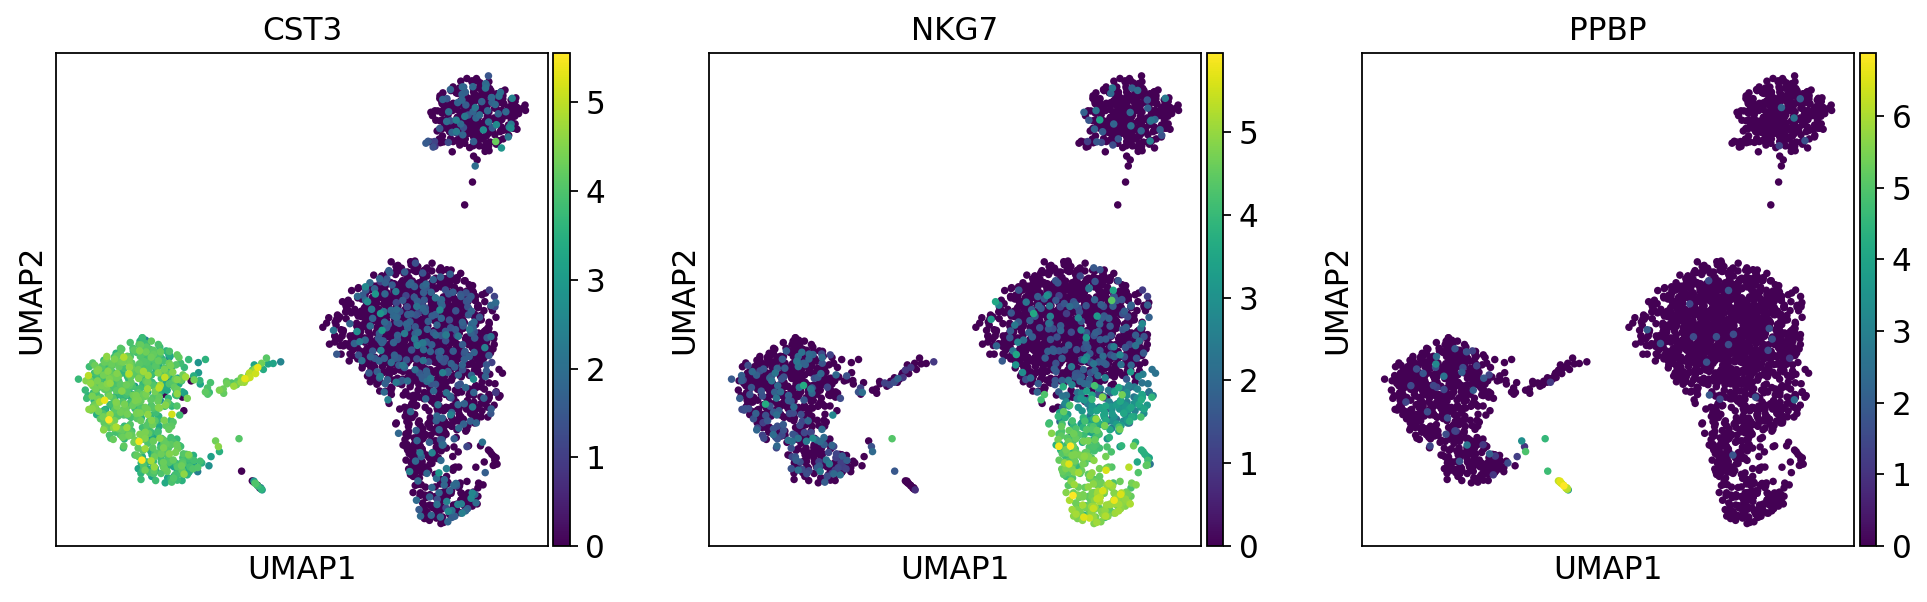

In [27]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [28]:
# Clustering the graph
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.18) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


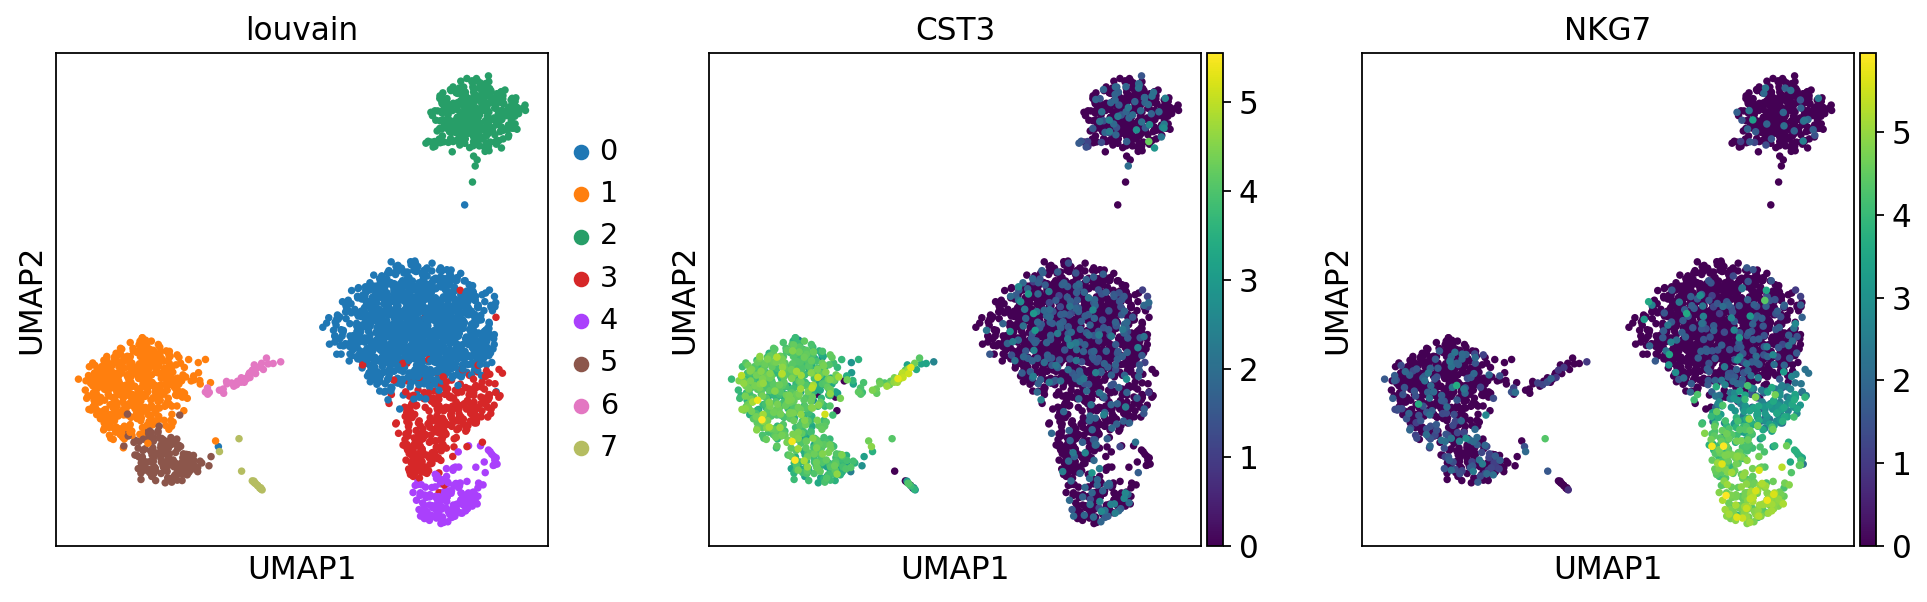

In [29]:
# Plot the data with tSNE. Coloring according to clustering. Clusters agree quite well with the result of Seurat.
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])
adata.write(results_file)

In [ ]:
# Finding marker genes

ranking genes
    finished (0:00:00.63) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


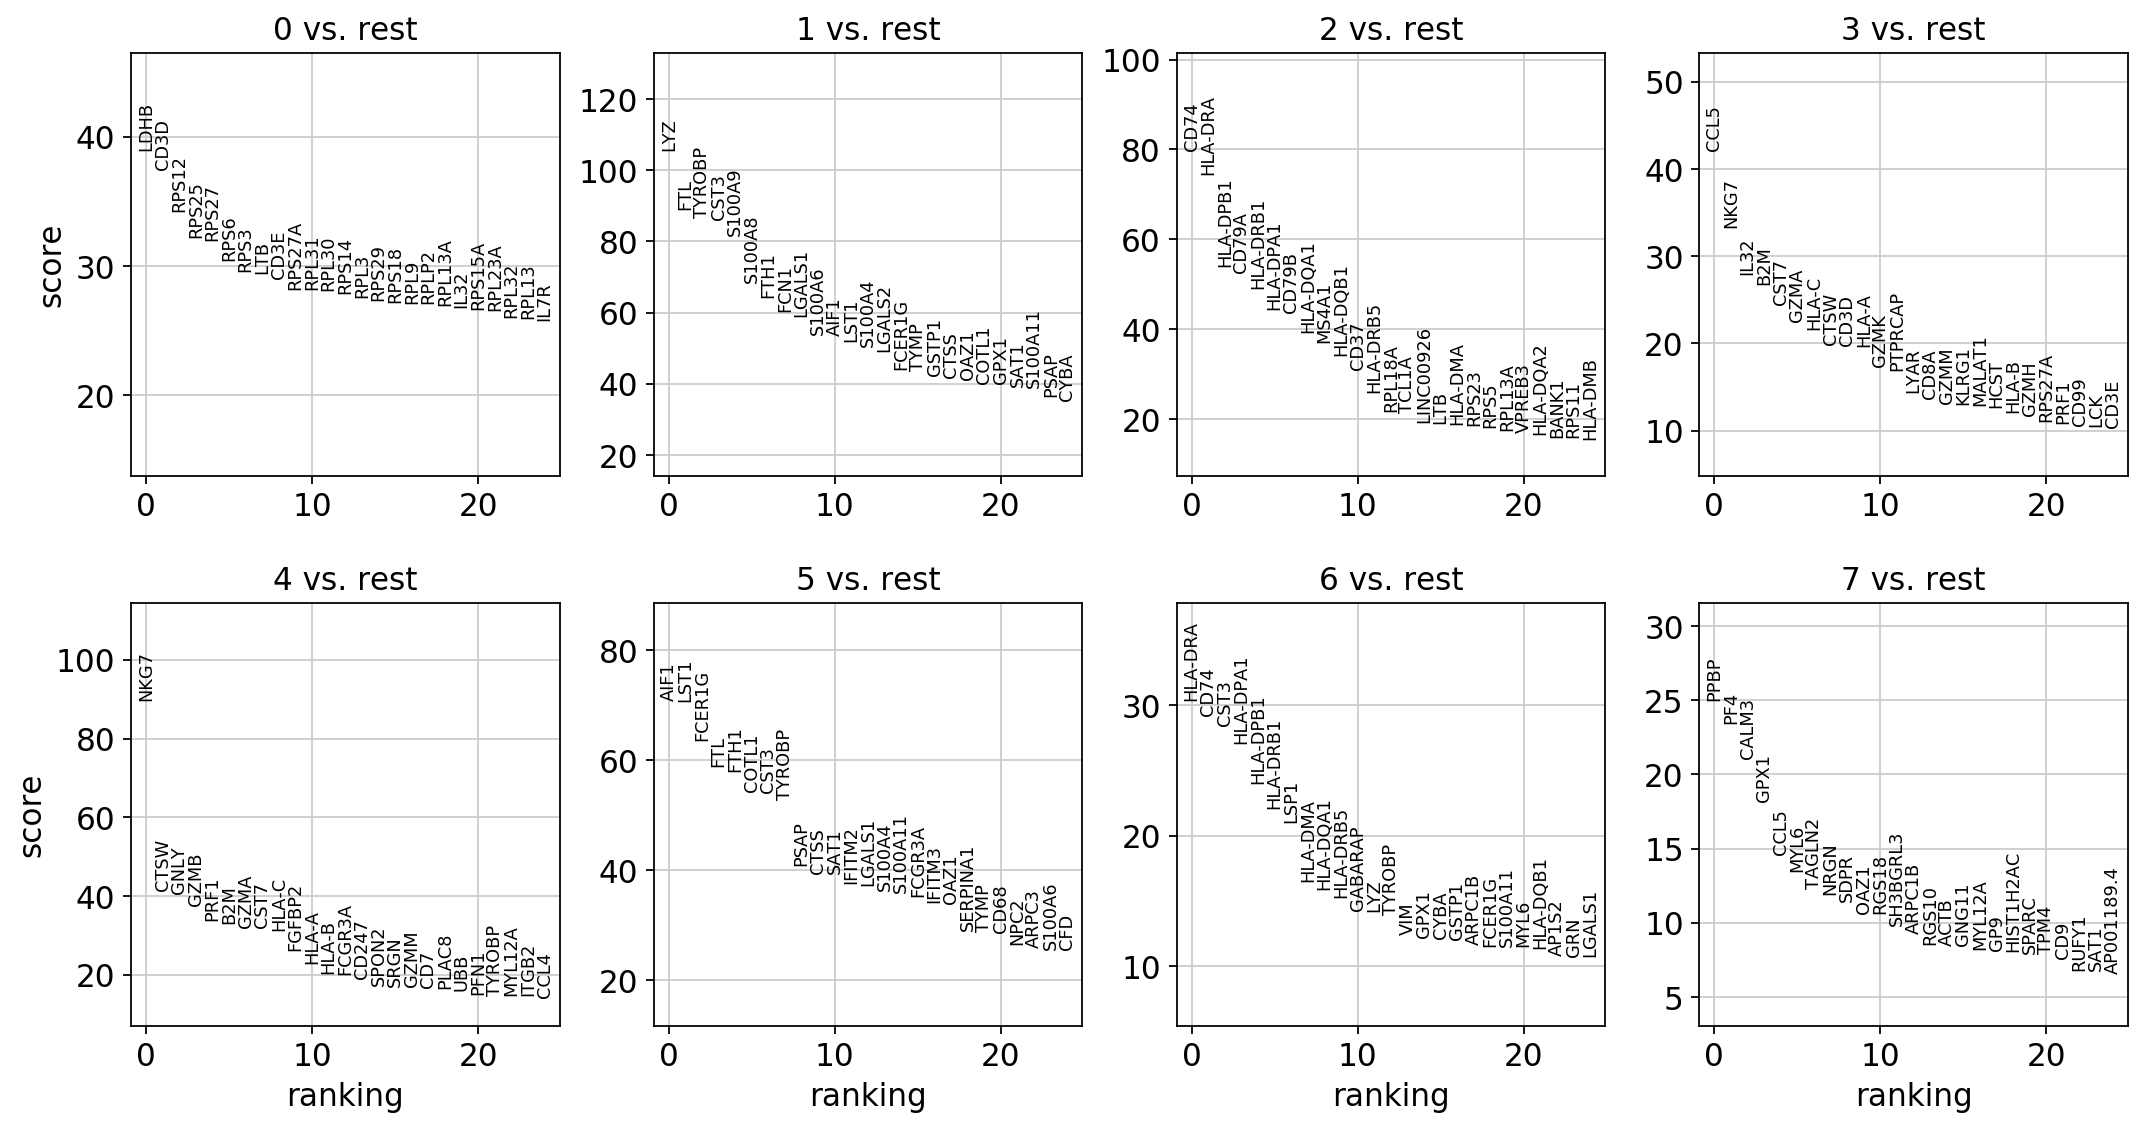

In [30]:
# Let us compute a ranking for the highly differential genes in each cluster. For this, 
# by default, the .raw attribute of AnnData is used in case it has been initialized before. 
# The simplest and fastest method to do so is the t-test.
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes


/home/gunnar/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gunnar/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


    finished (0:00:03.45) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids



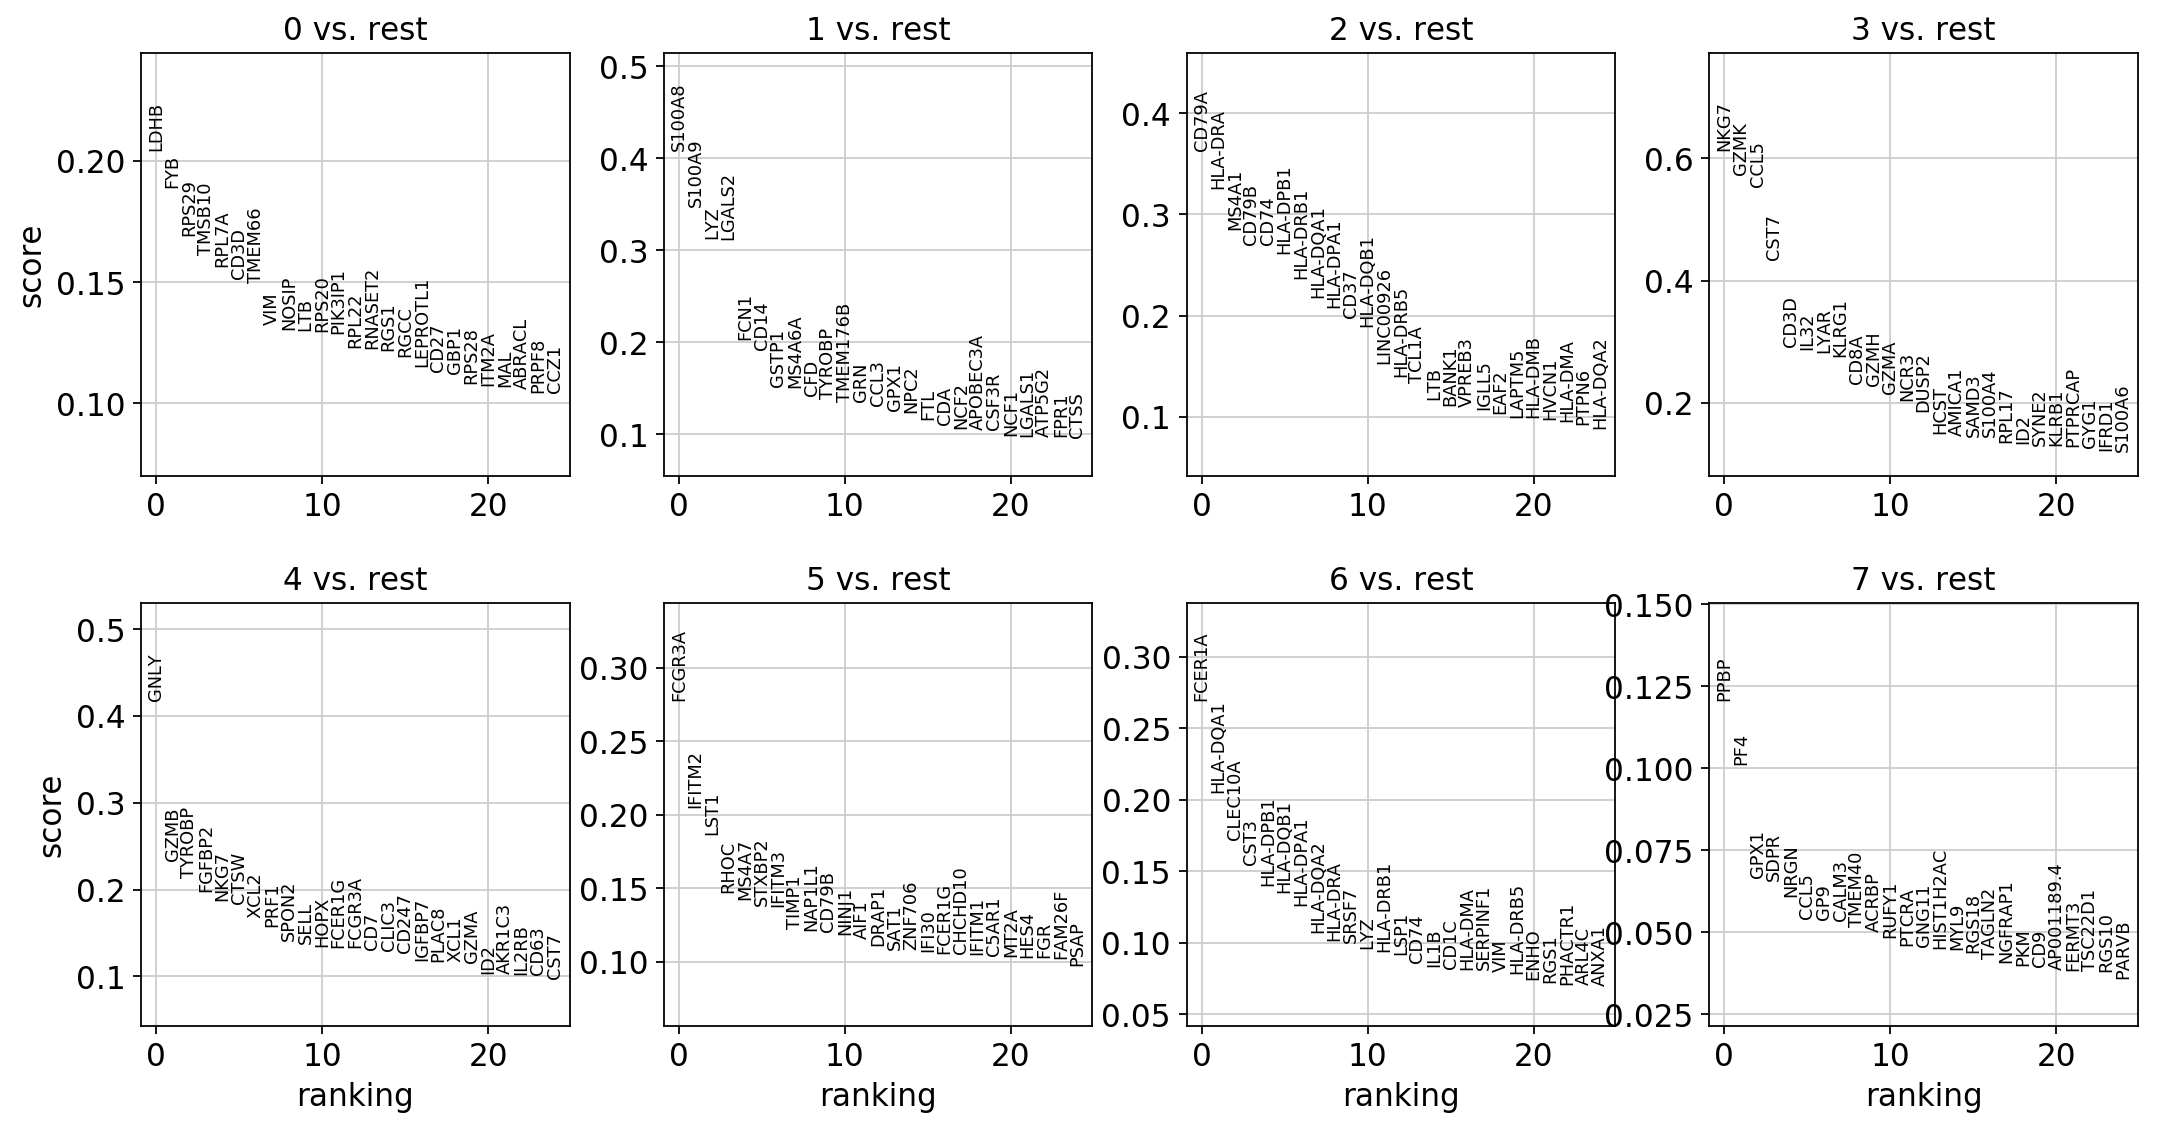

In [31]:
adata.write(results_file)
# As an alternative, let us rank genes using logistic regression. For instance, 
# this has been suggested by Natranos et al. (2018). The essential difference is that 
# here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. 
# Clark et al. (2014) has more details.
adata_copy = adata.copy()
sc.tl.rank_genes_groups(adata_copy, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata_copy, n_genes=25, sharey=False)

In [ ]:
# With the exceptions of IL7R, which is only found by the t-test and FCER1A, 
# which is only found by the other two appraoches, all marker genes are recovered in all approaches.


In [32]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [33]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1         2     3     4       5         6      7
0   LDHB     LYZ      CD74  CCL5  NKG7    AIF1   HLA-DRA   PPBP
1   CD3D     FTL   HLA-DRA  NKG7  CTSW    LST1      CD74    PF4
2  RPS12  TYROBP  HLA-DPB1  IL32  GNLY  FCER1G      CST3  CALM3
3  RPS25    CST3     CD79A   B2M  GZMB     FTL  HLA-DPA1   GPX1
4  RPS27  S100A9  HLA-DRB1  CST7  PRF1    FTH1  HLA-DPB1   CCL5

In [34]:
# Get a table with the scores and groups.
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n  1_p       2_n            2_p   3_n  \
0   LDHB  2.207563e-262     LYZ  0.0      CD74   0.000000e+00  CCL5   
1   CD3D  7.693815e-246     FTL  0.0   HLA-DRA   0.000000e+00  NKG7   
2  RPS12  3.798472e-208  TYROBP  0.0  HLA-DPB1  2.257926e-272  IL32   
3  RPS25  2.489225e-189    CST3  0.0     CD79A  1.606677e-169   B2M   
4  RPS27  1.394692e-186  S100A9  0.0  HLA-DRB1  2.281448e-243  CST7   

             3_p   4_n            4_p     5_n            5_p       6_n  \
0  4.733837e-149  NKG7  2.593381e-233    AIF1  6.024990e-247   HLA-DRA   
1  3.861772e-115  CTSW   1.068165e-97    LST1  3.835773e-206      CD74   
2  4.302269e-105  GNLY   3.966201e-87  FCER1G  7.490000e-193      CST3   
3  3.907152e-101  GZMB   8.431221e-82     FTL  4.056422e-217  HLA-DPA1   
4   3.653891e-77  PRF1   6.469934e-76    FTH1  5.169743e-192  HLA-DPB1   

            6_p    7_n           7_p  
0  6.562929e-32   PPBP  5.028116e-13  
1  2.552707e-31    PF4  1.229132e-12  
2  2.602294e-29  CALM3  2.473624e-12  
3  4.913713e-28   GPX1  2.596160e-11  
4  2.866306e-25   CCL5  4.517762e-10

ranking genes
    finished (0:00:01.62) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


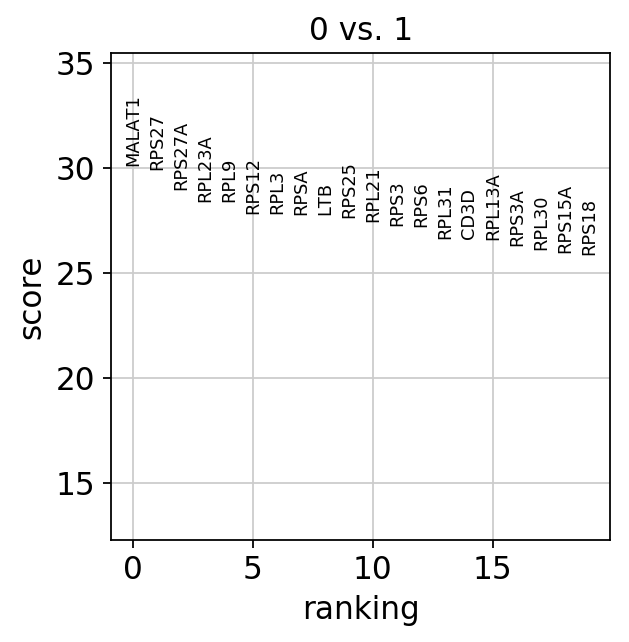

In [35]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

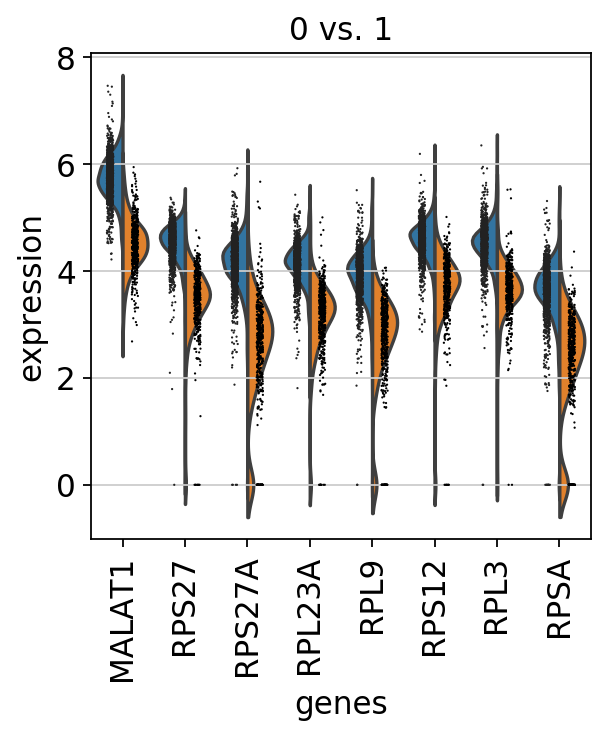

In [36]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

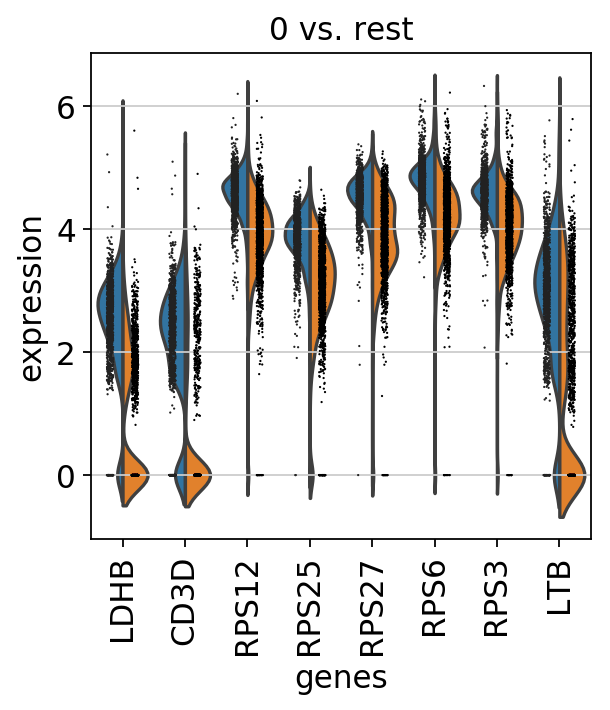

In [37]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

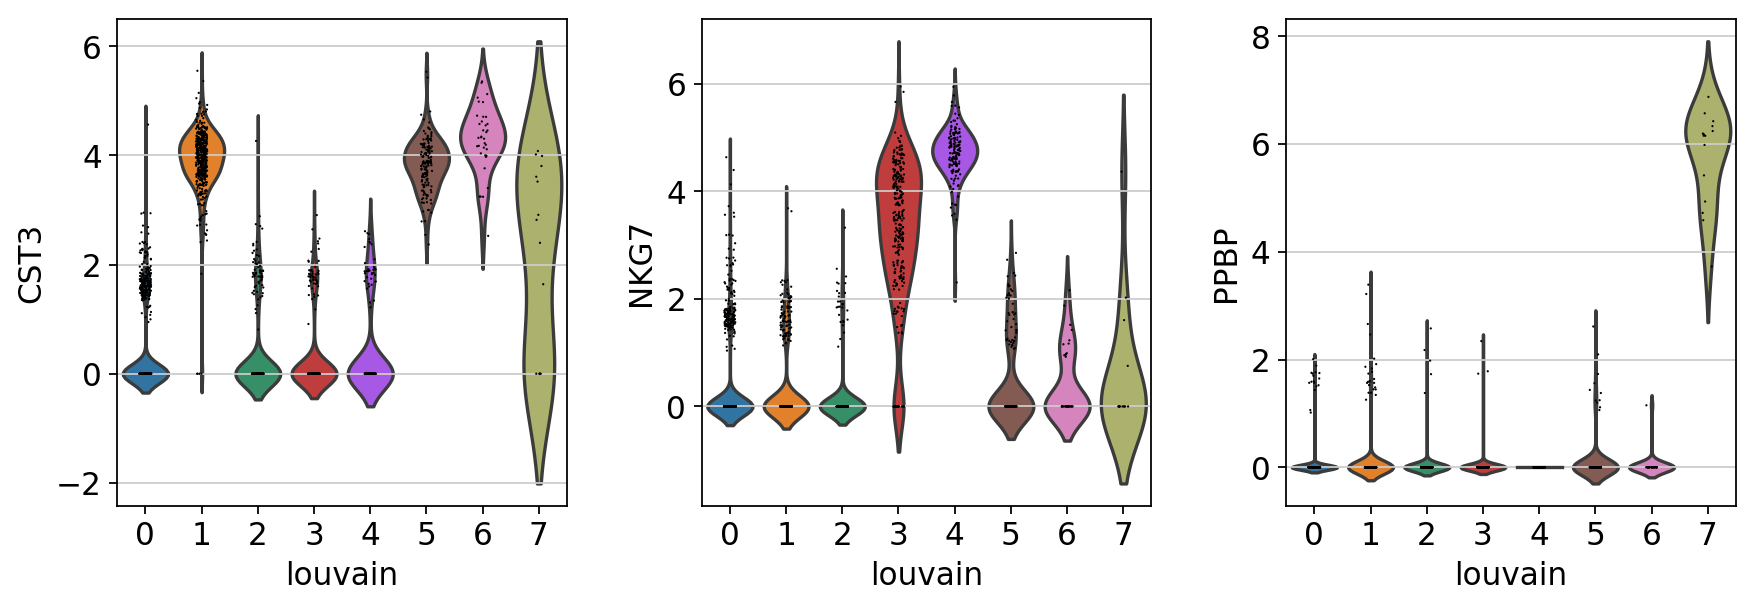

In [38]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

saving figure to file ./figures/umap.pdf


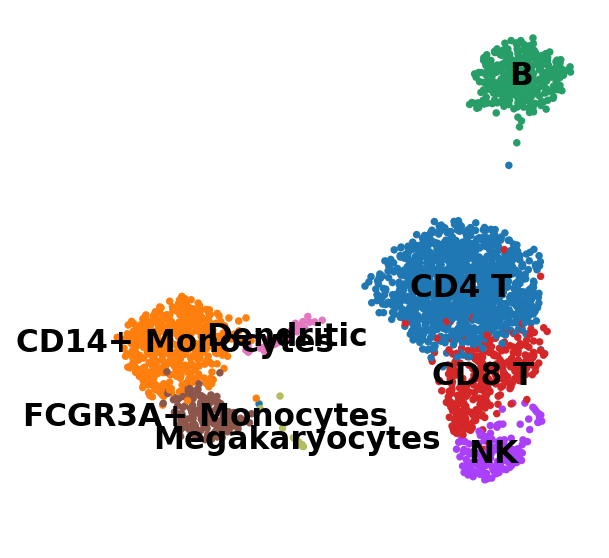

In [41]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

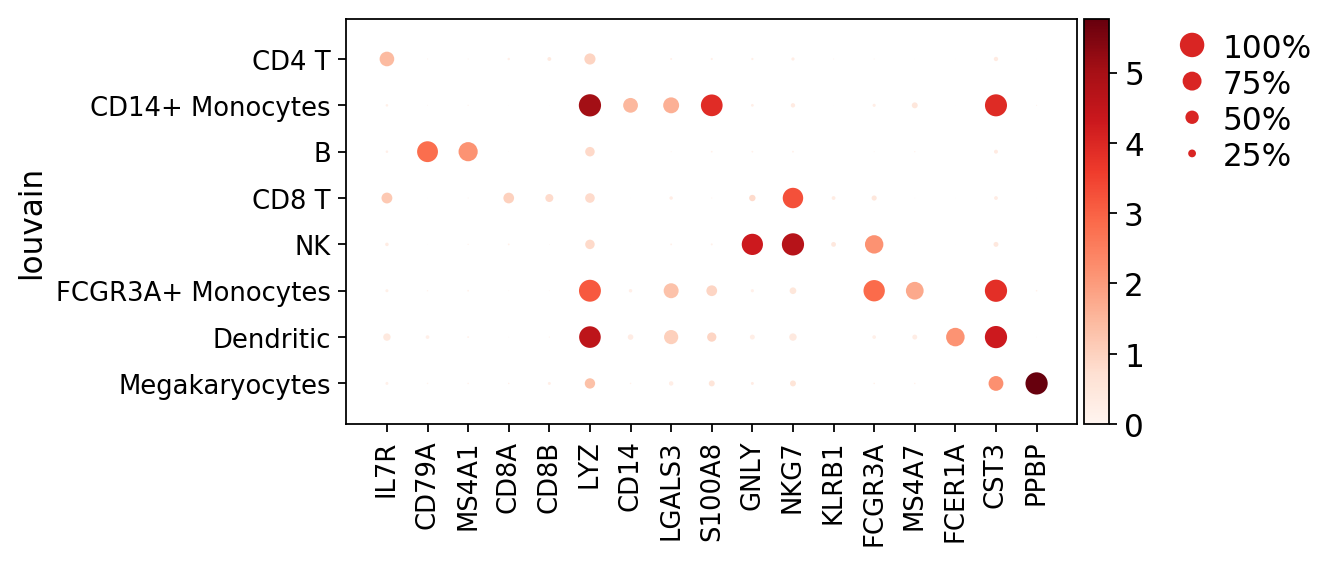

In [42]:
# visualizing the marker genes: 
gs = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

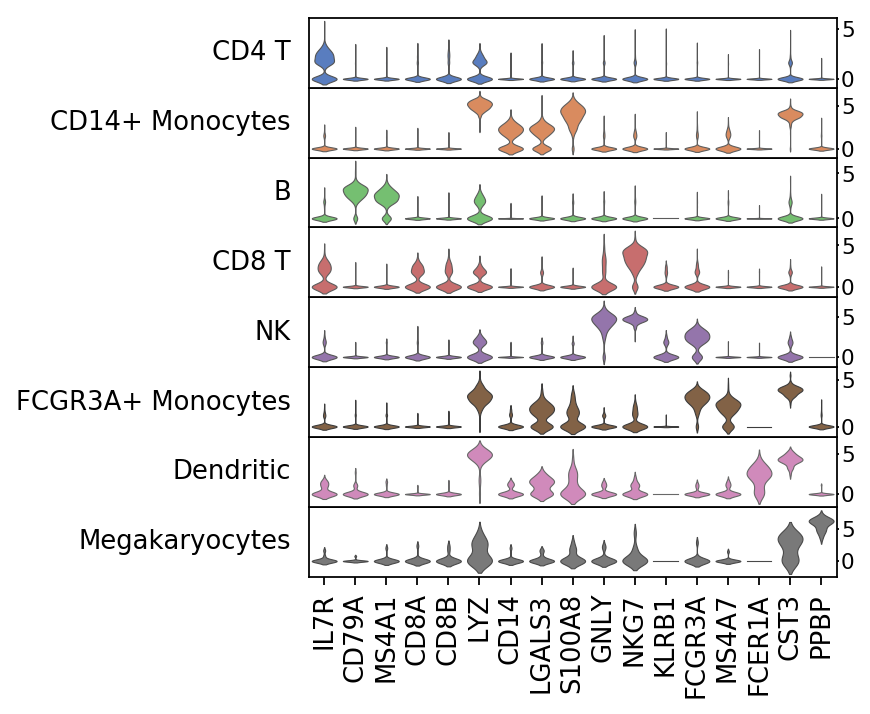

In [43]:
axs = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

In [45]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [46]:
adata.write(results_file)
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad')

In [48]:
# If you want to export to "csv", you have the following options:

# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )